# E_vs_r_scan
- - -

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Office of Data and Informatics, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-09-08

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 
 
- - -

## Introduction

The __E_vs_r_scan__ calculation creates a plot of the cohesive energy vs interatomic spacing, r, for a given atomic system. The system size is uniformly scaled (b/a and c/a ratios held fixed) and the energy is calculated at a number of sizes without relaxing the system. All box sizes corresponding to energy minima are identified. 

This calculation was created as a quick method for scanning the phase space of a crystal structure with a given potential in order to identify starting guesses for further structure refinement calculations.

__Disclaimer #1__: the minima identified by this calculation do not guarantee that the associated crystal structure will be stable as no relaxation is performed by this calculation. Upon relaxation, the atomic positions and box dimensions may transform the system to a different structure

__Disclaimer #2__: it is possible that the calculation may miss an existing minima for a crystal structure if it is ouside the range of r values scanned, or has b/a, c/a values far from the ideal.

## Demonstration

Library Imports

In [1]:
#Standard Python imports
import os
import shutil
from collections import OrderedDict
from copy import deepcopy

#http://matplotlib.org/
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#http://www.numpy.org/
import numpy as np

#https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

import iprPy

### 1. Generate Data Files

We have embedded a few files to make the Notebook a self-contained calculation.

1. __MEAM Potential.__ Generates library and parameter files for one MEAM potential.

2. __Potential Data Model.__ Collects all input parameters assoiciated with running the MEAM potential in LAMMPS.

3. __Prototype Data Model.__ Generates an instance of the crystal prototype data model used to generate various structures.

Create working directory

In [2]:
working_dir = 'E_vs_r_scan'

#This prevents recursive directories upon re-running this cell
if os.path.basename(os.getcwd()) == working_dir:
    working_dir = os.getcwd()
else:
    working_dir = os.path.realpath(working_dir)
    
#move to working_dir
try:
    os.chdir(working_dir)
except:
    os.makedirs(working_dir)
    os.chdir(working_dir)

#### 1.1 MEAM Potential

This generates the library and parameter files associated with the following interatomic potential taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

__2012--Jelinek-B--Al-Si-Mg-Cu-Fe__

__Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys__

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

__Notes__: This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

__Notice__: Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation. 

In [3]:
#Create MEAM library and parameter files for the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential
   
#Create MEAM library file "Jelinek_2012_meamf"
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

#### 1.2 Potential Data Model

This generates the interatomic potential data model file associated with the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential. Additional potential data models and their associated artifacts can be found in the ipyrPy/reference-libraries/potentials directory.

In [4]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
f = open('2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json', 'w')
f.write("""{
    "LAMMPS-potential": {
        "potential": {
            "key": "1515dd80-1984-49de-bc92-d5724059ff56", 
            "id": "2012--Jelinek-B--Al-Si-Mg-Cu-Fe"
        }, 
        "units": "metal", 
        "atom_style": "atomic", 
        "atom": [
            {
                "symbol": "AlS",
                "element": "Al", 
                "mass": 26.9815                
            }, 
            {
                "symbol": "SiS",
                "element": "Si", 
                "mass": 28.086                
            }, 
            {
                "symbol": "MgS", 
                "element": "Mg",
                "mass": 24.305                
            }, 
            {
                "symbol": "CuS", 
                "element": "Cu", 
                "mass": 63.54
            }, 
            {
                "symbol": "FeS", 
                "element": "Fe", 
                "mass": 55.847
            }
        ], 
        "pair_style": {
            "type": "meam"
        }, 
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                }, 
                {
                    "symbolsList": "True"
                }, 
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                }, 
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")
f.close()    

#### 1.3 Prototype Data Model

This generates the crystal prototype data model file associated with the AuCu L1<sub>0</sub> crystal prototype. Additional prototype data models can be found in the ipyrPy/reference-libraries/prototypes directory.

In [5]:
#Creates an instance of a crystal prototype data model for generating crystal structures.
f = open('L1_0--AuCu.json', 'w')
f.write("""{
    "crystal-prototype": {
        "identifier": {
            "common": "AuCu", 
            "tag": "AuCu", 
            "prototype": "AuCu", 
            "Pearson-symbol": "tP4", 
            "Strukturbericht": "L1_0"
        }, 
        "space-group": {
            "number": 123, 
            "Hermann-Maguin": "P 4/m m m", 
            "Schoenflies": "D4h^1"
        }, 
        "atomic-system": {
            "cell": {
                "tetragonal": {
                    "a": {
                        "value": 1.0, 
                        "unit": "scaled"
                    }, 
                    "c": {
                        "value": 0.926, 
                        "unit": "scaled"
                    }
                }
            }, 
            "atom": [
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.5, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.0, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 2, 
                    "position": {
                        "value": [
                            0.0, 
                            0.0, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 2, 
                    "position": {
                        "value": [
                            0.5, 
                            0.5, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }
            ]
        }
    }
}""")
f.close()

### 2. LAMMPS Script Template(s)

This generates any LAMMPS imput template files that are used by the calculation functions. The calculation functions fill in variable terms in the templates to create complete LAMMPS simulation scripts.

1. run0.template -- Statically evaluates the potential energy of a system without relaxation.

#### 2.1 run0.template

In [6]:
f = open('run0.template', 'w')
f.write("""#LAMMPS input script that evaluates the energy of a system without relaxation

<atomman_system_info>

<atomman_pair_info>

variable peatom equal pe/atoms
                  
thermo_style custom step lx ly lz pxx pyy pzz pe v_peatom
thermo_modify format float %.13e

run 0""")
f.close()

### 3. Python Calculation Function(s)

These are the Python functions that are at the heart of performing the calculation.

1. __e_vs_r__: computes the cohesive energy, _Ecoh_, of a system as a function of interatomic spacing, _r_, over a range of _r_ values. Identifies all system configurations corresponding to energy minimums.

2. __r_a_ratio__: identifies the shortest interatomic spacing, _r_, for a system and returns it relative to the _a_ lattice parameter.


#### 3.1 e_vs_r Function

Uses LAMMPS and the run0.template script to evaluate the cohesive energy, _Ecoh_, as a function of interatomic spacing, _r_,  for a specific system-potential-symbols.

Arguments:
    
- __lammps_command__ -- command for running LAMMPS.
- __system__ -- atomman.System to perform the scan on.
- __potential__ -- atomman.lammps.Potential representation of a LAMMPS implemented potential.
- __symbols__ -- list of element-model symbols for the Potential that correspond to system's atypes.
    
Keyword Arguments:
    
- __mpi_command__ -- MPI command for running LAMMPS in parallel. Default value is None (serial run).  
- __ucell__ -- an atomman.System representing a fundamental unit cell of the system. If not given, ucell will be taken as system. 
- __rmin__ -- the minimum _r_ spacing to use. Default value is 2.0.
- __rmax__ -- the maximum _r_ spacing to use. Default value is 6.0.
- __rsteps__ -- the number of _r_ spacing steps to evaluate. Default value is 200.

Returns a dictionary containing:

- __r_values__ -- a list of the _r_ values used.

- __a_values__ -- a list of the _a_ lattice parameter values corresponding to r_values.

- __Ecoh_values__ -- a list of the _Ecoh_ values corresponding to r_values.

- __min_cell__ -- a list of atomman.Systems with positions based on ucell and lattice dimensions corresponding to measured _r_ values with minimum _Ecoh_ values.


This code is directly copied from calc_E_vs_r_scan.py.

In [7]:
def e_vs_r(lammps_command, system, potential, symbols, mpi_command=None, ucell=None, rmin=2.0, rmax=6.0, rsteps=200):        
    """
    Performs a cohesive energy scan over a range of interatomic spaces, r.
    
    Arguments:
    lammps_command -- command for running LAMMPS.
    system -- atomman.System to perform the scan on.
    potential -- atomman.lammps.Potential representation of a LAMMPS 
                 implemented potential.
    symbols -- list of element-model symbols for the Potential that 
               correspond to system's atypes.
    
    Keyword Arguments:
    
    mpi_command -- MPI command for running LAMMPS in parallel. Default value 
                   is None (serial run).  
    ucell -- an atomman.System representing a fundamental unit cell of the 
             system. If not given, ucell will be taken as system. 
    rmin -- the minimum r spacing to use. Default value is 2.0.
    rmax -- the minimum r spacing to use. Default value is 6.0.
    rsteps -- the number of r spacing steps to evaluate. Default value is 200.    
    """
    
    #Make system a deepcopy of itself (protect original from changes)
    system = deepcopy(system)
    
    #Set ucell = system if ucell not given
    if ucell is None:
        ucell = system
    
    #Calculate the r/a ratio for the unit cell
    r_a = r_a_ratio(ucell)
    
    #Get ratios of lx, ly, and lz of system relative to a of ucell
    lx_a = system.box.a / ucell.box.a
    ly_a = system.box.b / ucell.box.a
    lz_a = system.box.c / ucell.box.a
    alpha = system.box.alpha
    beta =  system.box.beta
    gamma = system.box.gamma
 
    #build lists of values
    r_values = np.linspace(rmin, rmax, rsteps)
    a_values = r_values / r_a
    Ecoh_values = np.empty(rsteps)
 
    #Loop over values
    for i in xrange(rsteps):
        
        #Rescale system's box
        a = a_values[i]
        system.box_set(a = a * lx_a, 
                       b = a * ly_a, 
                       c = a * lz_a, 
                       alpha=alpha, beta=beta, gamma=gamma, scale=True)
        
        #Get lammps units
        lammps_units = lmp.style.unit(potential.units)
        
        #Define lammps variables
        lammps_variables = {}
        lammps_variables['atomman_system_info'] = lmp.atom_data.dump(system, 'atom.dat', units=potential.units, atom_style=potential.atom_style)
        lammps_variables['atomman_pair_info'] = potential.pair_info(symbols)
        
        #Write lammps input script
        template_file = 'run0.template'
        lammps_script = 'run0.in'
        with open(template_file) as f:
            template = f.read()
        with open(lammps_script, 'w') as f:
            f.write('\n'.join(iprPy.tools.fill_template(template, lammps_variables, '<', '>')))

        #Run lammps and extract data
        output = lmp.run(lammps_command, lammps_script, mpi_command)
        Ecoh_values[i] = uc.set_in_units(output.finds('peatom')[-1], lammps_units['energy'])
        shutil.move('log.lammps', 'run0-'+str(i)+'-log.lammps')
           
    #Find unit cell systems at the energy minimums
    min_cells = []
    for i in xrange(1, rsteps - 1):
        if Ecoh_values[i] < Ecoh_values[i-1] and Ecoh_values[i] < Ecoh_values[i+1]:
            a = a_values[i]
            cell = deepcopy(ucell)
            cell.box_set(a = a,
                         b = a * ucell.box.b / ucell.box.a,
                         c = a * ucell.box.c / ucell.box.a, 
                         alpha=alpha, beta=beta, gamma=gamma, scale=True)
            min_cells.append(cell)        
            
    return {'r_values':    r_values, 
            'a_values':    a_values, 
            'Ecoh_values': Ecoh_values, 
            'min_cell':    min_cells}

#### 3.2 r_a_ratio Function

Calculates the shortest interatomic spacing, r, for a system wrt to lattice constant _a_ for a system.

Arguments:

- __ucell__ -- atomman.System to calculate r/a for.

Returns the r/a ratio.

This code is directly copied from calc_E_vs_r_scan.py.

In [8]:
def r_a_ratio(ucell):
    """Calculates the shortest interatomic spacing, r, for a system wrt to box.a."""
    r_a = ucell.box.a
    for i in xrange(ucell.natoms):
        for j in xrange(i):
            dmag = np.linalg.norm(ucell.dvect(i,j))
            if dmag < r_a:
                r_a = dmag
    return r_a/ucell.box.a

### 4. Run Calculation

Specify run parameters

In [9]:
#Commands for LAMMPS and MPI
lammps_command = 'lmp_serial'
mpi_command =    None

#Paths to the potential data model and directory of artifacts
potential_file = '2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json' #Generated above
potential_dir  = ''                                     #Files generated above in working directory

#System load parameters
load_style = 'system_model'
load_file =  'L1_0--AuCu.json' #Generated above

#Specify symbols combinations to use
symbols_lists = [['AlS', 'AlS'], 
                 ['AlS', 'SiS'], 
                 ['AlS', 'MgS'],
                 ['AlS', 'CuS'],
                 ['AlS', 'FeS']]

#Range of r values to use
rmin = 2.0
rmax = 6.0
rsteps = 100

Read the interatomic potential data model

In [10]:
with open(potential_file) as f:
    potential = lmp.Potential(f, potential_dir)

Read the prototype ucell system

In [11]:
ucell = am.load(load_style, load_file)[0]

Make a supercell system of ucell

In [12]:
system = am.supersize(ucell, 3, 3, 3)

Perform e_vs_r calculation for every set of symbols

In [13]:
results = OrderedDict()

#Iterate over all sets of symbols
for symbols in symbols_lists:
    name = '-'.join(symbols)
    
    results[name] = e_vs_r(lammps_command, system, potential, symbols, 
                           mpi_command=mpi_command, ucell=ucell, 
                           rmin=rmin, rmax=rmax, rsteps=rsteps)   

### 5. Display Results

Plot _Ecoh_ vs. _r_ 

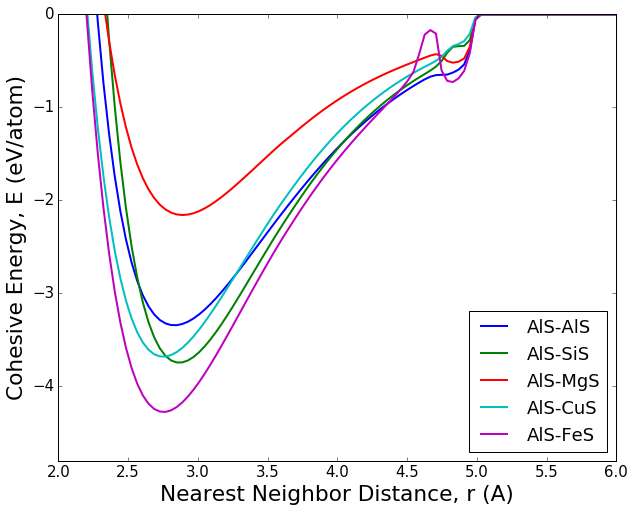

In [14]:
#Initial plot setup
matplotlib.rc('lines',lw=2)
matplotlib.rc('font',size=15)
plt.figure(figsize=(10,8))   
emin = 0.0

#plot values
for name in results:
    plt.plot(results[name]['r_values'], results[name]['Ecoh_values'], lw=2, label=name) 
    if min(results[name]['Ecoh_values']) < emin: 
        emin = min(results[name]['Ecoh_values'])

#Final plot setup and show
plt.legend(loc=0)
plt.xlabel('Nearest Neighbor Distance, r (A)', size='x-large')
plt.ylabel('Cohesive Energy, E (eV/atom)', size='x-large')
plt.ylim(round(emin, 1)-.5, 0.0)
plt.xlim(rmin, rmax)
plt.show()   

Show the minimum energy cells

In [15]:
for name in results:
    for cell in results[name]['min_cell']:
        print name
        print cell
        print

AlS-AlS
avect =  [ 4.180,  0.000,  0.000]
bvect =  [ 0.000,  4.180,  0.000]
cvect =  [ 0.000,  0.000,  3.871]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 2
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   2.090 |   1.935
      1 |       1 |   2.090 |   0.000 |   1.935
      2 |       2 |   0.000 |   0.000 |   0.000
      3 |       2 |   2.090 |   2.090 |   0.000

AlS-SiS
avect =  [ 4.180,  0.000,  0.000]
bvect =  [ 0.000,  4.180,  0.000]
cvect =  [ 0.000,  0.000,  3.871]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 2
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   2.090 |   1.935
      1 |       1 |   2.090 |   0.000 |   1.935
      2 |       2 |   0.000 |   0.000 |   0.000
      3 |       2 |   2.090 |   2.090 |   0.000

AlS-MgS
avect =  [ 4.239,  0.000,  0.000]
bvect =  [ 0.000,  4.239,  0.000]
cvect =  [ 0.000,  0.000,  3.926]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 2
     id |   atype